In [2]:
%matplotlib inline
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm
from tvm import te

In [3]:
# Save to the d2ltvm package.
def plot(X, Y, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear', fmts=None,
         figsize=(4.5, 3)):
    """Plot multiple lines"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    axes = plt.gca()
    X, Y = np.array(X), np.array(Y)
    if X.shape != Y.shape: X = [X] * len(Y)
    if not fmts: fmts = ['-'] * len(X)
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x, y, fmt)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend: axes.legend(legend)
    axes.grid()

# Save to the d2ltvm package
def plot_gflops(sizes, gflops, legend, xlabel='Size'):
    plot(sizes, gflops, xlabel=xlabel, ylabel='GFLOPS',
             xscale='log', yscale='log',
             legend=legend, fmts=['--']*(len(gflops)-1)+['-'])

In [4]:
def bench_workload(workload):
    """Benchmark a workload
    workload: a method that accept a num_repeat argument
    and return its total execution time
    """
    workload(1)  # warmup
    time = workload(1)  # the time to run once
    if time > 1: return time
    # The number of repeats to measure at least 1 second
    num_repeats = max(int(1.0 / time), 5)
    return workload(num_repeats) / num_repeats

/tmp/ipykernel_11338/2110144406.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


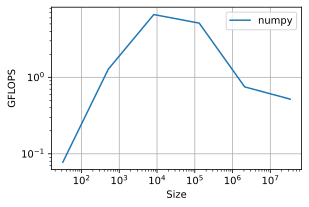

In [5]:
sizes = 2**np.arange(5, 29, 4)
np_add = lambda n: timeit.Timer(setup='import numpy as np\n'
                                'import utils\n'
                                'a, b, c = utils.get_abc(%d)' % n,
                                stmt='np.add(a, b, out=c)')
exe_times = [bench_workload(np_add(n).timeit) for n in sizes]
np_gflops = sizes / 1e9 / np.array(exe_times)
plot_gflops(sizes, [np_gflops], ['numpy'])

In [25]:
import utils

def bench_vector_add_tvm(func, sizes, target):
    def workload(nrepeats):
        dev = tvm.device(target)
        timer = mod.time_evaluator(mod.entry_name, dev=dev, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(int(n))
        mod = tvm.build(s, [A, B, C], target)
        a, b, c = utils.get_abc(n, lambda x: tvm.nd.array(x))
        times.append(bench_workload(workload))
    return sizes / 1e9 / np.array(times)

In [9]:
def vector_add(n):
    """TVM expression for vector add"""
    A = te.placeholder((n,), name='a')
    B = te.placeholder((n,), name='b')
    C = te.compute(A.shape, lambda i: A[i] + B[i], name='c')
    return A, B, C

In [10]:
def default(n):
    A, B, C = vector_add(n)
    s = te.create_schedule(C.op)
    return s, (A, B, C)

s, args = default(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(a_1: handle, b_1: handle, c_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {a: Buffer(a_2: Pointer(float32), float32, [64], []),
             b: Buffer(b_2: Pointer(float32), float32, [64], []),
             c: Buffer(c_2: Pointer(float32), float32, [64], [])}
  buffer_map = {a_1: a, b_1: b, c_1: c}
  preflattened_buffer_map = {a_1: a_3: Buffer(a_2, float32, [64], []), b_1: b_3: Buffer(b_2, float32, [64], []), c_1: c_3: Buffer(c_2, float32, [64], [])} {
  for (i: int32, 0, 64) {
    c[i] = (a[i] + b[i])
  }
}




In [11]:
target = 'llvm -mcpu=tigerlake'
mod = tvm.build(s, args, target)
print(mod.get_source()[:500])

; ModuleID = 'TVMMod'
source_filename = "TVMMod"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-pc-linux-gnu"

%0 = type { i8*, %1, i32, %2, i64*, i64*, i64 }
%1 = type { i32, i32 }
%2 = type { i8, i8, i16 }

@__TVMAPISetLastError = linkonce dllexport local_unnamed_addr global void (i8*)* null, align 8
@.str = private constant [69 x i8] c"Assert fail: (num_args == 3), default_function: num_args should be 3\00", align 1
@.str.1


/tmp/ipykernel_11338/2110144406.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


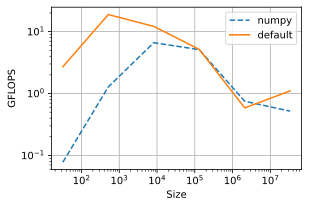

In [26]:
default_gflops = bench_vector_add_tvm(default, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops], ['numpy', 'default'])

In [27]:
def parallel(n):
    s, (A, B, C) = default(n)
    # add thread-level parallelism
    s[C].parallel(C.op.axis[0])
    return s, (A, B, C)

s, args = parallel(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(a_1: handle, b_1: handle, c_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {a: Buffer(a_2: Pointer(float32), float32, [64], []),
             b: Buffer(b_2: Pointer(float32), float32, [64], []),
             c: Buffer(c_2: Pointer(float32), float32, [64], [])}
  buffer_map = {a_1: a, b_1: b, c_1: c}
  preflattened_buffer_map = {a_1: a_3: Buffer(a_2, float32, [64], []), b_1: b_3: Buffer(b_2, float32, [64], []), c_1: c_3: Buffer(c_2, float32, [64], [])} {
  for (i: int32, 0, 64) "parallel" {
    c[i] = (a[i] + b[i])
  }
}




/tmp/ipykernel_11338/2110144406.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


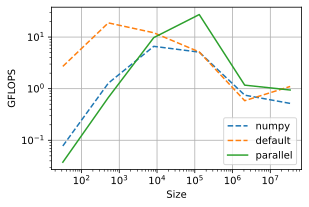

In [28]:
parallel_gflops = bench_vector_add_tvm(parallel, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops, parallel_gflops],
     ['numpy', 'default', 'parallel'])

In [29]:
def vectorized(n):
    s, (A, B, C) = default(n)
    outer, inner = s[C].split(C.op.axis[0], factor=8)
    s[C].parallel(outer)
    s[C].vectorize(inner)
    return s, (A, B, C)

s, args = vectorized(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(a_1: handle, b_1: handle, c_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {a: Buffer(a_2: Pointer(float32), float32, [64], []),
             b: Buffer(b_2: Pointer(float32), float32, [64], []),
             c: Buffer(c_2: Pointer(float32), float32, [64], [])}
  buffer_map = {a_1: a, b_1: b, c_1: c}
  preflattened_buffer_map = {a_1: a_3: Buffer(a_2, float32, [64], []), b_1: b_3: Buffer(b_2, float32, [64], []), c_1: c_3: Buffer(c_2, float32, [64], [])} {
  for (i.outer: int32, 0, 8) "parallel" {
    let cse_var_1: int32 = (i.outer*8)
    c[ramp(cse_var_1, 1, 8)] = (a[ramp(cse_var_1, 1, 8)] + b[ramp(cse_var_1, 1, 8)])
  }
}




/tmp/ipykernel_11338/2110144406.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


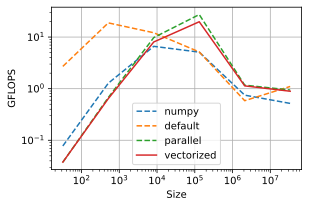

In [30]:
vectorized_gflops = bench_vector_add_tvm(vectorized, sizes, target)
plot_gflops(sizes, [np_gflops, default_gflops, parallel_gflops, vectorized_gflops],
     ['numpy', 'default', 'parallel', 'vectorized'])